In [1]:
#### Setting up ####
import os
import re
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy

from matplotlib.colors import LinearSegmentedColormap

sc.settings.savefigs = False

mpl.rcParams['figure.figsize'] = [4.0, 4.0]
mpl.rcParams['grid.alpha'] = 0.0

sc.settings.verbosity = 3
sc.logging.print_header()

#results_file = './write/BM200930.h5ad'  # the file that will store the analysis results

#### Loading Data ####
os.chdir("file directory")
filename_Buffy210208 = "filtered_feature_bc_matrix.h5"

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


scanpy==1.7.2 anndata==0.7.5 umap==0.4.6 numpy==1.20.2 scipy==1.5.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
# Reading in actual 10x file
adata_full = sc.read_10x_h5(filename_Buffy210208, gex_only=False)
adata_full.var_names_make_unique()

reading filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:01)


In [3]:
adata_full

AnnData object with n_obs × n_vars = 4391 × 36602
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata_full.X.todense()

matrix([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         9.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         9.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         7.000e+00],
        ...,
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         3.274e+03],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         5.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         6.598e+03]], dtype=float32)

In [5]:
adata_full.var["feature_types"].value_counts()

Gene Expression     36601
Antibody Capture        1
Name: feature_types, dtype: int64

In [6]:
adata_full.var["feature_types"].value_counts()

Gene Expression     36601
Antibody Capture        1
Name: feature_types, dtype: int64

In [7]:
adata_full.var['feature_types']

MIR1302-2HG                       Gene Expression
FAM138A                           Gene Expression
OR4F5                             Gene Expression
AL627309.1                        Gene Expression
AL627309.3                        Gene Expression
                                       ...       
AC023491.2                        Gene Expression
AC007325.1                        Gene Expression
AC007325.4                        Gene Expression
AC007325.2                        Gene Expression
TotalSeqB0953_PE_Streptavidin    Antibody Capture
Name: feature_types, Length: 36602, dtype: object

In [8]:
# Split Ab feature from GeneEx features
protein = adata_full[:, adata_full.var["feature_types"] == "Antibody Capture"].copy()
adata = adata_full[:, adata_full.var["feature_types"] == "Gene Expression"].copy()

In [9]:
protein.obs_names

Index(['AAACCCAAGACCTTTG-1', 'AAACCCACAACACAGG-1', 'AAACCCACACTTCTCG-1',
       'AAACCCACATAGACTC-1', 'AAACCCATCACTTATC-1', 'AAACCCATCCTCACGT-1',
       'AAACCCATCGTCCTCA-1', 'AAACGAAGTAGATCGG-1', 'AAACGAAGTGGGAGAG-1',
       'AAACGCTCAGATAAAC-1',
       ...
       'TTTGGAGTCCAATCCC-1', 'TTTGGAGTCCGCATAA-1', 'TTTGGTTAGCGTGTTT-1',
       'TTTGGTTAGCTTAAGA-1', 'TTTGGTTAGTATAGGT-1', 'TTTGTTGCAATCGTCA-1',
       'TTTGTTGGTAGCGCCT-1', 'TTTGTTGGTTACGCCG-1', 'TTTGTTGTCAGCTTGA-1',
       'TTTGTTGTCAGGGTAG-1'],
      dtype='object', length=4391)

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

normalizing counts per cell
    finished (0:00:00)


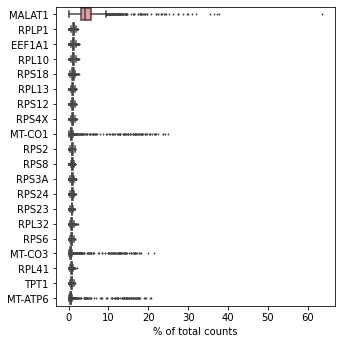

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [12]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 102 cells that have less than 500 genes expressed
filtered out 15921 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical
... storing 'genome' as categorical


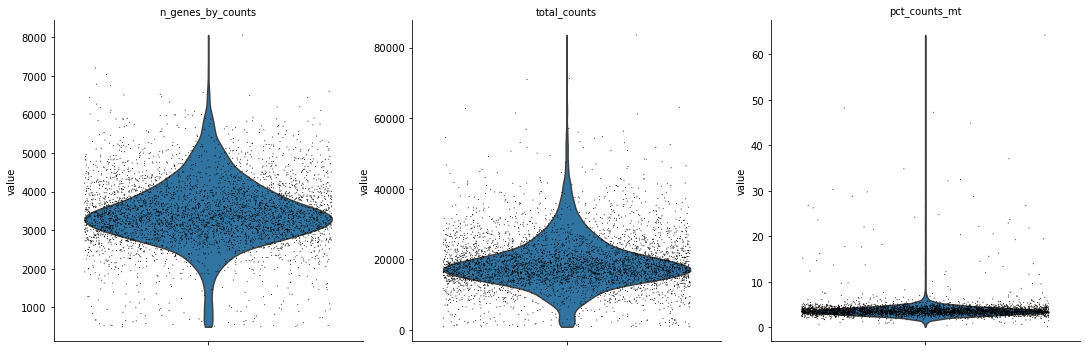

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

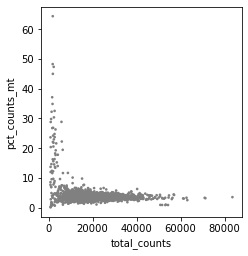

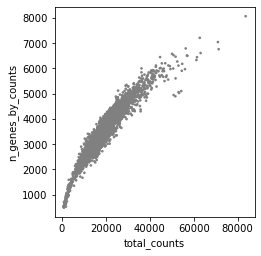

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
# Previous landscape annotation based on 30% mt cutoff
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.pct_counts_mt < 6, :]

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


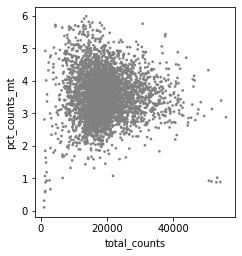

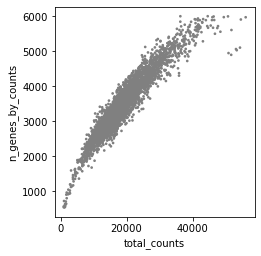

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
adata_gene_full = adata.copy()
adata.raw = adata
sc.pp.recipe_zheng17(adata, log=True)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00)


Preprocessing...


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 48.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 3.8 seconds


99

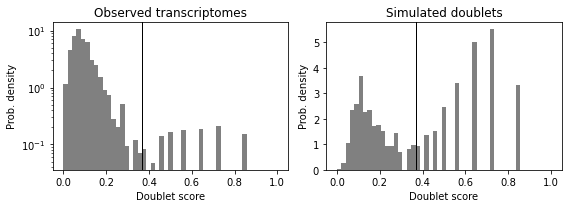

In [18]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [19]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


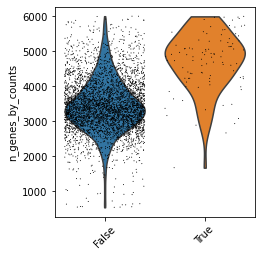

In [20]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


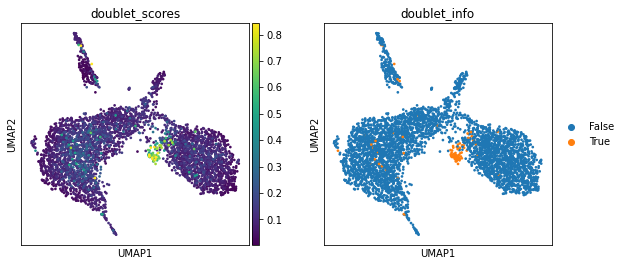

In [22]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info'])

In [23]:
print(adata.shape)
adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(4162, 999)
(4063, 999)


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [24]:
adata = adata.raw.to_adata() 
adata = adata[adata.obs['doublet_info'] == 'False',:]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 4063 × 20680
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts_all', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'doublet_info_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'

In [26]:
processed_cell_barcodes = adata.obs_names

In [27]:
protein_full = protein.copy()
protein = protein[processed_cell_barcodes]

In [28]:
protein

View of AnnData object with n_obs × n_vars = 4063 × 1
    var: 'gene_ids', 'feature_types', 'genome'

In [29]:
adata_gene_full = adata.copy()
adata.raw = adata
sc.pp.recipe_zheng17(adata, log=True)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:00)


In [30]:
# Normalise "raw counts" layer
adata2 = sc.AnnData(X=adata_gene_full.X, var=adata_gene_full.var, obs=adata_gene_full.obs)
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
adata.raw = adata2

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [31]:
# Loading and removal of cell cycle genes
cell_cycle_genes_file = 'reactome_human_cell_cycle.txt'
with open(cell_cycle_genes_file) as f: 
    cell_cycle_genes = [line.strip('\n') for line in f.readlines()]

# Identify genes correlating with cell cycle genes and remove
gene_correlation = np.corrcoef(adata.X.transpose())
gene_correlation_cell_cycle = gene_correlation[
    [i for i, gene in enumerate(adata.var_names) if gene in cell_cycle_genes], :]

high_correlation_gene_filter = np.amax(gene_correlation_cell_cycle, axis=0) < 0.2
cell_cycle_removed_genes = adata.var_names[np.invert(high_correlation_gene_filter)]
adata = adata[:, high_correlation_gene_filter]

# See how many cells and genes left after filtering
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data have', nGenes, 'genes in', nCells, 'cells')

Data have 759 genes in 4063 cells


/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15)
# sc.tl.louvain(adata)
# Optimum reso is n=15, reso was 0.8 thus far
sc.tl.leiden(adata, resolution=0.9)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


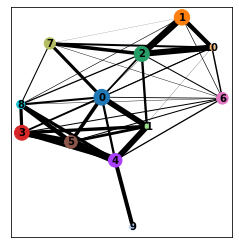

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [33]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color='leiden')
sc.tl.umap(adata)

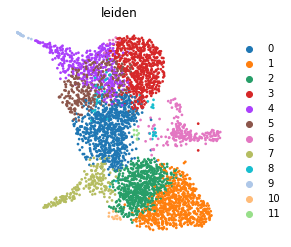

In [34]:
sc.pl.umap(adata, color='leiden', frameon=False,
           #save='annotated_2Jun21.pdf'
          )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


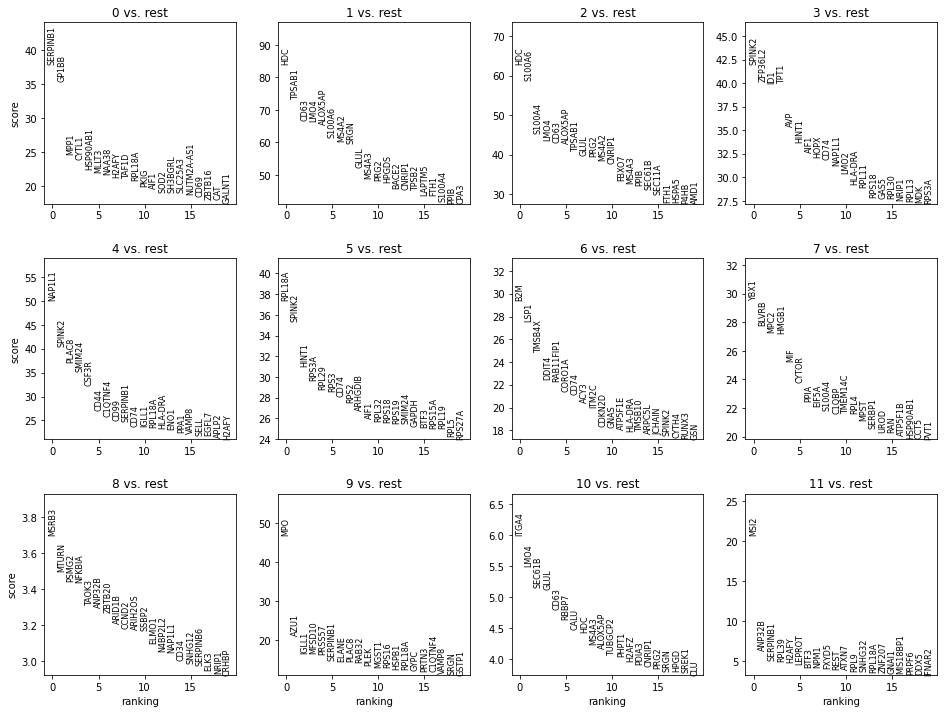

In [35]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups(adata, sharey=False)

In [36]:
#sc.tl.draw_graph(adata, init_pos = 'paga')
#sc.pl.draw_graph(adata, color='leiden')

In [62]:
Dahlin_marker_genes_revised = {'MCP-like': ['GATA2', 'CPA3', 'TPSB2', 'CMA1', 'IL3RA', 'IL5RA', 'CLC', 'CSF2RB', 'HDC', 'TPSD1', 'HPGDS'],
'Baso/Eo': ['CEBPA', 'MITF', 'RNASE2', 'EPX', 'RNASE3'],
'Neu': ['ELANE', 'MPO', 'PRTN3', 'AZU1'],
'Ery': ['KLF1', 'HBB', 'CA1'],
'HSCs': ['SPINK2', 'CRHBP', 'PCDH9', 'AVP'],
'DC': ['CLEC9A', 'IRF8', 'MPEG1'],
'Mono': ['S100A9', 'LYZ', 'MS4A6A', 'ANXA2', 'CSF1R'],
'Lym': ['DNTT', 'CD79A', 'VPREB1'],
'MK': ['ITGA2B', 'PLEK', 'VWF'],
'B': ['JCHAIN', 'IGHM', 'MS4A1'],
'NK': ['LTB', 'KLRB1', 'IL7R', 'NKG7']}

In [38]:
# Create a color_map for clearer annotation
color_list = ['lightgrey', 'silver', 'coral', 'darkred']
cmap = LinearSegmentedColormap.from_list("color_trial", colors=color_list)
color_list_less_grey = ['lightgrey', 'tomato', 'firebrick', 'darkred']
cmap_less_grey = LinearSegmentedColormap.from_list("color_trial", colors=color_list_less_grey)

In [39]:
adata.raw.shape

(4063, 20680)

In [57]:
for n in adata.raw.var_names:
    if n.startswith("CXC"):
        print(n)

CXCR4
CXCL8
CXCL6
CXCL3
CXCL2
CXCL14
CXCL12
CXCR5
CXCL16
CXCR3


MCP-like


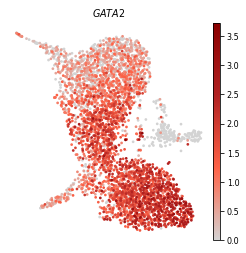

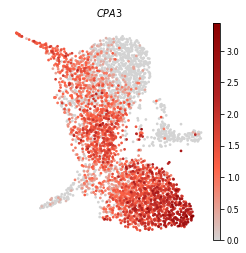

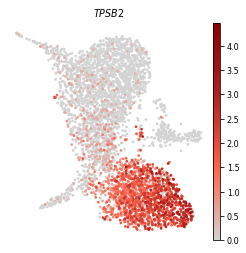

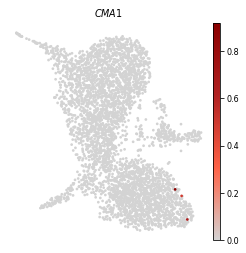

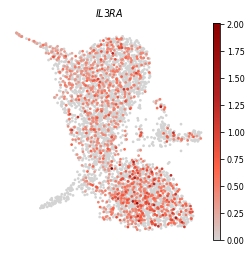

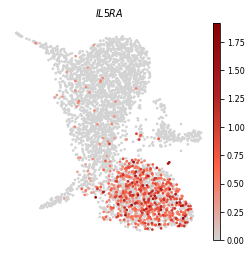

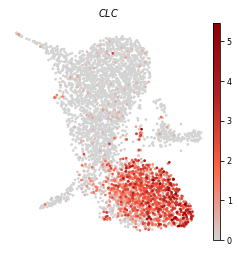

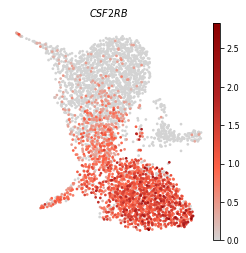

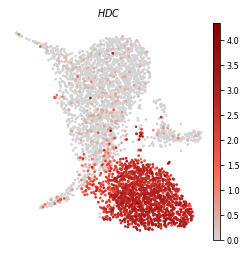

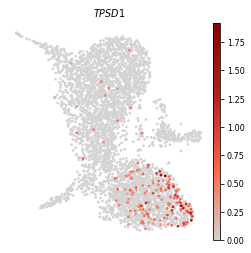

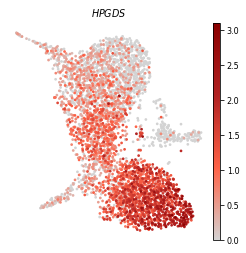

Baso/Eo


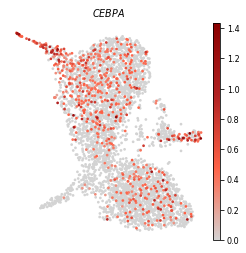

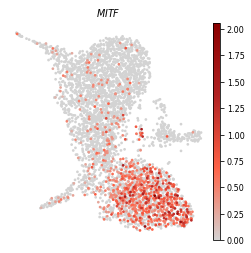

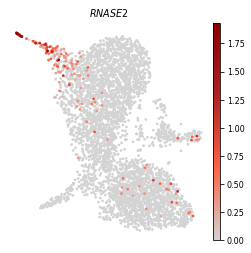

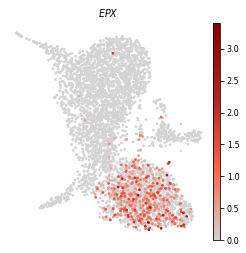

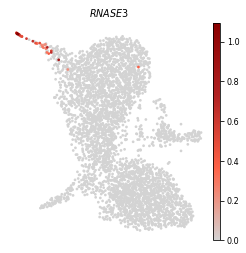

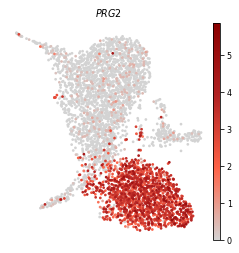

Neu


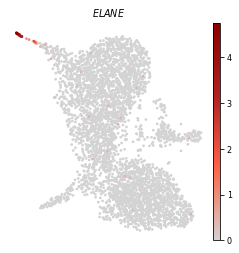

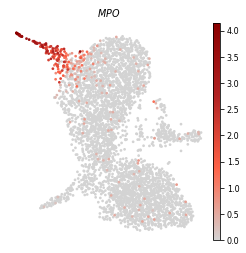

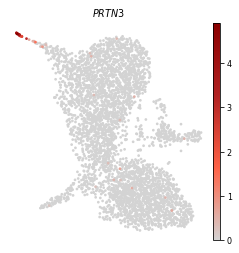

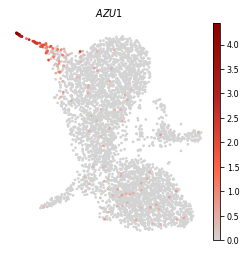

Ery


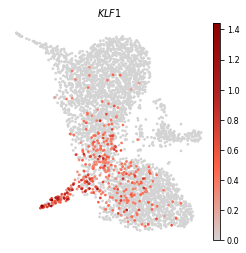

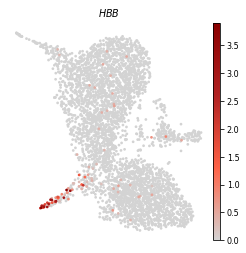

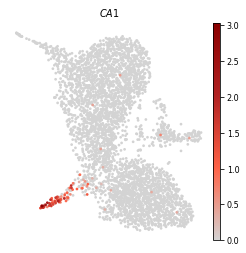

HSCs


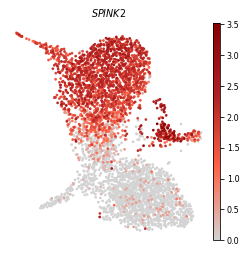

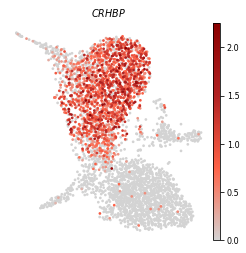

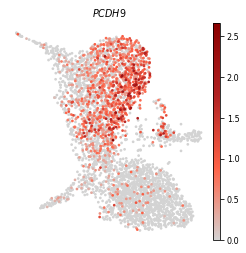

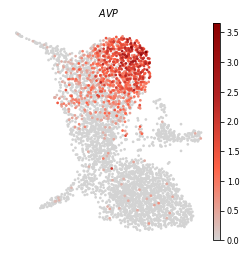

DC


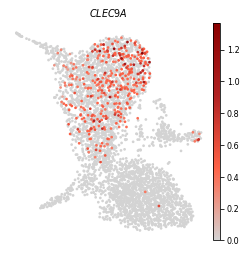

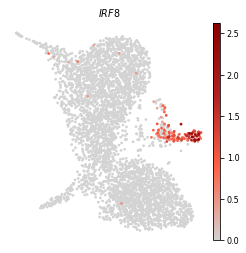

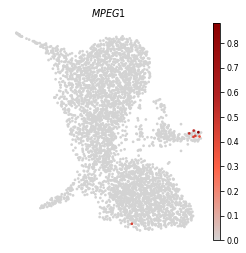

Mono


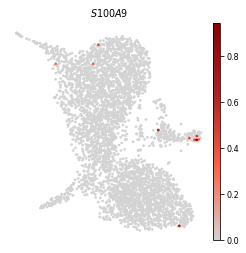

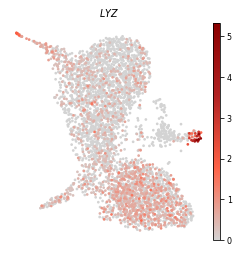

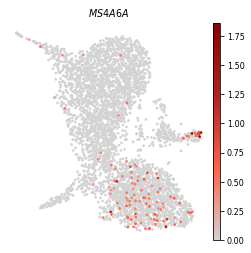

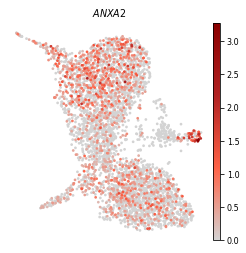

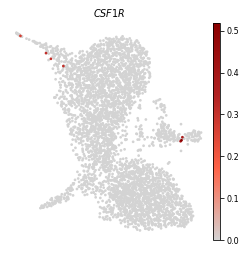

Lym


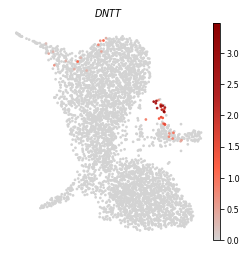

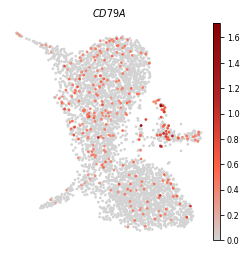

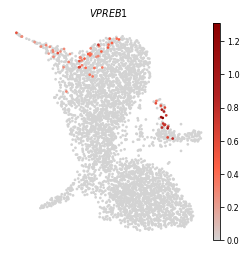

MK


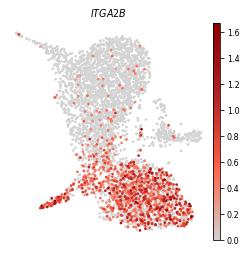

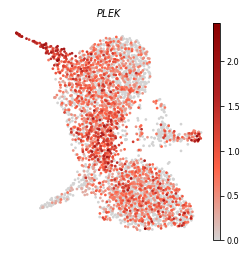

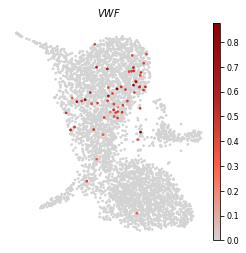

B


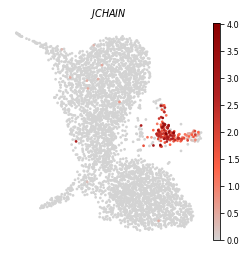

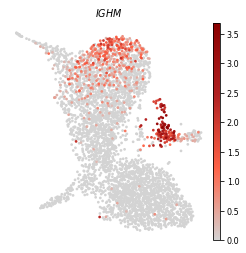

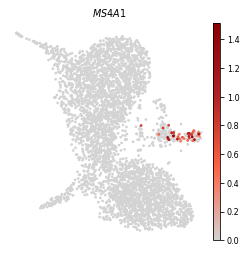

NK


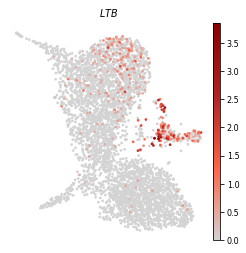

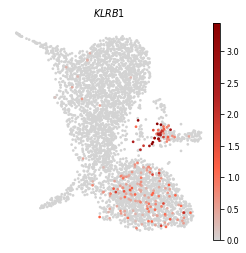

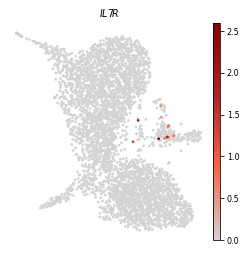

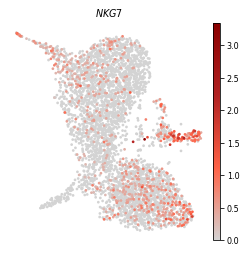

In [59]:
for cell_group, genes in Dahlin_marker_genes_revised.items():
    print(cell_group)
    for gene in genes:
        font = {'size'   : 8}
        mpl.rc('font', **font)
        sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False, title=f"$\mathit{{{gene}}}$")

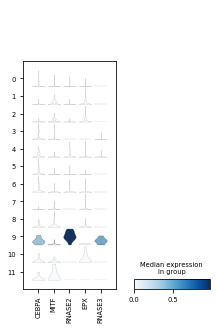

In [63]:
sc.pl.stacked_violin(adata, Dahlin_marker_genes_revised['Baso/Eo'], groupby='leiden')

In [ ]:
cluster_A_markers = ['TPSAB1', 'TPSB2', 'HDC', 'FCER1A', 'MS4A2', 'FCER1G']
for gene in cluster_A_markers:
    sc.pl.umap(adata, color=gene, use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str('clusterA' + gene + '10Jun2021' + '.pdf')
              )

In [ ]:
cytokine_receptors = ['IL3RA', 'IL5RA', 'CSF2RA', 'CSF2RB', 'IL1RL1', 'EPOR', 'MPL', 'FLT3']
for gene in cytokine_receptors:
    sc.pl.umap(adata, color=gene, color_map=cmap_less_grey, use_raw=True,
              #save=str('/cytokines/' + gene + '2Jun2021'),
               frameon=False)

In [ ]:
for cell_group, genes in Dahlin_marker_genes_revised.items():
    print(cell_group)
    for gene in genes:
        font = {'size'   : 8}
        mpl.rc('font', **font)
        mpl.rcParams['figure.figsize'] = [1.3750, 1.4583]
        mpl.rcParams['savefig.dpi'] = 200
        sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str(cell_group + gene + '10Jun2021' + '.png'),
                  #title=f"$\mathit{{{gene}}}$",
                  size=5)

In [44]:
mpl.rcParams['figure.figsize'] = [4, 4]

In [45]:
# No scaling due to single feature, only logging of counts
protein.X = sc.pp.log1p(protein.X.todense())

In [46]:
adata.obs['Total_SeqB_Streptavidin'] = protein.to_df()

In [47]:
adata

AnnData object with n_obs × n_vars = 4063 × 759
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts_all', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden', 'Total_SeqB_Streptavidin'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'doublet_info_colors', 'pca', 'neighbors', 'umap', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


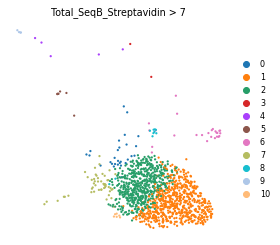

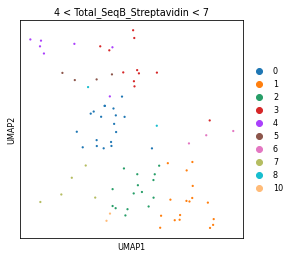

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


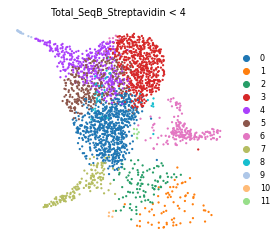

In [48]:
sc.pl.umap(adata[adata.obs.loc[
    adata.obs['Total_SeqB_Streptavidin'] > 7].index.tolist(), ]
           , color= 
['leiden'], title=['Total_SeqB_Streptavidin > 7'], size=20,
           #save='step>7_2Jun21.pdf',
           frameon=False)

index_range = []
for i, n in adata.obs['Total_SeqB_Streptavidin'].iteritems():
    if 4 <= n <= 7:
        index_range.append(i)

sc.pl.umap(adata[adata.obs.loc[index_range].index.tolist(),]
           , color= 
['leiden'], title=['4 < Total_SeqB_Streptavidin < 7'], size=20)

sc.pl.umap(adata[adata.obs.loc[
    adata.obs['Total_SeqB_Streptavidin'] < 4].index.tolist(), ]
           , color= 
['leiden'], title=['Total_SeqB_Streptavidin < 4'], size=20,
           #save='step<4_2Jun21.pdf',
           frameon=False)

In [49]:
strep_pos = len(adata.obs.loc[adata.obs['Total_SeqB_Streptavidin'] > 7])
strep_neg = len(adata.obs.loc[adata.obs['Total_SeqB_Streptavidin'] < 4])
count = 0
for i, n in adata.obs['Total_SeqB_Streptavidin'].iteritems():
    if 4 <= n <= 7:
        count += 1
strep_btw = count
strep_all = len(adata.obs)
population_pos = strep_pos / strep_all
population_btw = strep_btw / strep_all
population_neg = strep_neg / strep_all
print(population_pos)
print(population_btw)
print(population_neg)

0.32488309131183857
0.02092050209205021
0.6541964065961112


In [50]:
# Calculate population frequencies
Strep_pos_df = adata.obs.loc[adata.obs['Total_SeqB_Streptavidin'] > 7]
Strep_mid_df = adata.obs.loc[index_range]
Strep_neg_df = adata.obs.loc[adata.obs['Total_SeqB_Streptavidin'] <= 4]

strep_pos_freq = Strep_pos_df['Total_SeqB_Streptavidin'].value_counts()
strep_neg_freq = Strep_neg_df['Total_SeqB_Streptavidin'].value_counts()

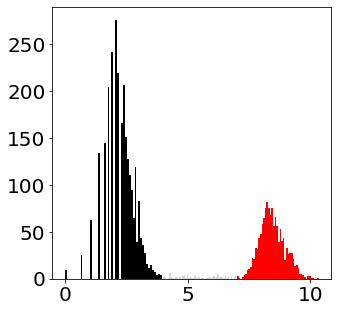

In [51]:
plt.figure(figsize=(5,5))
bin_n = 50
plt.hist(Strep_pos_df['Total_SeqB_Streptavidin'], bins=bin_n, label='PE > 7', color='red')
plt.hist(Strep_mid_df['Total_SeqB_Streptavidin'], bins=bin_n, label='PE >4, <7', color='lightgrey')
plt.hist(Strep_neg_df['Total_SeqB_Streptavidin'], bins=bin_n, label='PE < 4', color='black')
#plt.legend(loc='upper right', fontsize=14)
#plt.xlabel("log1p counts", fontsize=14)
#plt.title("Freq distribution of PE ab in landscape")
plt.tick_params(labelsize=20)
#plt.savefig('./figures/cell_hash_gate_10Jun2021.pdf')
plt.show()

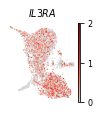

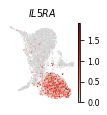

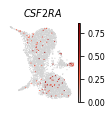

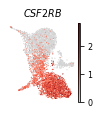

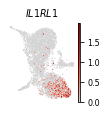

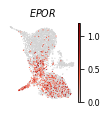

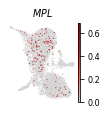

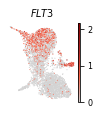

In [52]:
cytokine_receptors = ['IL3RA', 'IL5RA', 'CSF2RA', 'CSF2RB', 'IL1RL1', 'EPOR', 'MPL', 'FLT3']
for gene in cytokine_receptors:    
    font = {'size'   : 8}
    mpl.rc('font', **font)
    mpl.rcParams['figure.figsize'] = [1.3750, 1.4583]
    mpl.rcParams['savefig.dpi'] = 200
    sc.pl.umap(adata, color=[gene], use_raw=True, 
                   color_map=cmap_less_grey, frameon=False,
                  #save=str('cytokine_receptors' + gene + '10Jun2021' + '.png'),
                  title=f"$\mathit{{{gene}}}$",
                  size=5)

In [53]:
mpl.rcParams['figure.figsize'] = [4, 4]

In [54]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '3')[0]
sc.tl.diffmap(adata)
sc.tl.dpt(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.98746717 0.98169386 0.97584444 0.94437754 0.94012785
     0.9306627  0.91418463 0.90940243 0.905058   0.9005656  0.8891166
     0.8866015  0.86809754 0.8538184 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


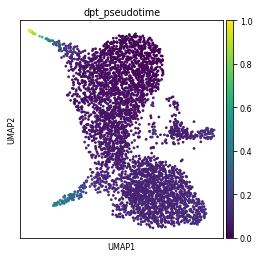

In [55]:
sc.pl.umap(adata, color='dpt_pseudotime')
#sc.pl.draw_graph(adata, color='dpt_pseudotime')

In [4]:
# Creating new Anndata object with raw values, but with existing obs
adata2 = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs
                    , uns=adata.uns, obsm=adata.obsm)

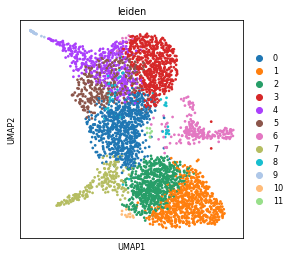

In [57]:
sc.pl.umap(adata, color='leiden')

In [5]:
# Define paths for separate trajectories
# Critical! To set order as "categories" and not numerical
path_dict = {'path_MCP' : ['3', '0', '2', '1']}

path_MCP = path_dict['path_MCP']

from pandas.api.types import CategoricalDtype
path_MCP_s = CategoricalDtype(
    ['3', '0', '2', '1'],
    ordered=True)

#####  Dynamic gene regulation vis a vis Hamey et al (2020) and Tusi et al
Cycle through sliding window of n cells for each gene, looking for a maxima window and minima window, using pseudotime+leiden ranking. T-test for p-value scores. The same number of cells are then scrambled, taking a new maxima and minima, to create a background distribution. The fraction of shuffled p-values across all genes less than the p-value for the gene in question is used as the adjusted p-value (ordered data).

In [59]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [60]:
from scipy import stats

# Generate ordered and unordered pvalues
window_size = 60 # Tusi et al, window size n=100, to try changing
gene_test = adata.raw.var_names

stat_list = []
for gene in gene_test:
    gene_df = sc.get.obs_df(adata2, 
                            keys=[gene, 'dpt_pseudotime', 'leiden'])
    MC_path_df = gene_df[gene_df['leiden'].isin(path_MCP)]
    # Set leiden grouping as categories to enable sorting
    MC_path_df['leiden'] = MC_path_df['leiden'].astype(path_MCP_s)
    #cutoff_val = MC_path_df[MC_path_df['leiden'] == '2']['dpt_pseudotime'].max()
    #MC_path_df = MC_path_df[MC_path_df['dpt_pseudotime'] <= cutoff_val]
    MC_path_df = MC_path_df.sort_values(['leiden', 'dpt_pseudotime'], ascending=[True, True])

    sorted_gene_df = MC_path_df.drop(['leiden', 'dpt_pseudotime'], axis=1)
    sorted_gene_arr = sorted_gene_df[gene].to_numpy()

    # Create ordered windows and p-values
    windows = rolling_window(sorted_gene_arr, window_size)
    maxima_index = np.argmax(np.mean(windows, axis=1))
    minima_index = np.argmin(np.mean(windows, axis=1))
    stat = stats.ttest_ind(windows[maxima_index], windows[minima_index])

    # Shuffle cell order and recreate shuffled windows and p-values
    np.random.shuffle(sorted_gene_arr)
    shuffled_windows = rolling_window(sorted_gene_arr, window_size)
    shuffle_max_index = np.argmax(np.mean(shuffled_windows, axis=1))
    shuffled_min_index = np.argmin(np.mean(shuffled_windows, axis=1))
    shuffled_stat = stats.ttest_ind(shuffled_windows[shuffle_max_index], shuffled_windows[shuffled_min_index])
    
    stat_dict = dict([('pvalue', stat[1]), ('shuffle_pvalue', shuffled_stat[1]), ('gene', gene)])
    stat_list.append(stat_dict)

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [61]:
stat_MCP_df = pd.DataFrame.from_records(stat_list, index='gene')
stat_MCP_clean = stat_MCP_df.dropna()

In [62]:
# Calculating adj pvalue as fraction of scrambled genes with lower pval
fraction_list = []
for i, row in stat_MCP_clean.iterrows():
    gene_pval = row['pvalue']
    lower = stat_MCP_clean['shuffle_pvalue'][stat_MCP_clean['shuffle_pvalue'] < gene_pval].count()
    fraction_lower = lower / len(stat_MCP_clean.index)
    pval_dict = dict([('gene', i), ('adj pvalue', fraction_lower)])
    fraction_list.append(pval_dict)

In [63]:
fraction_df = pd.DataFrame.from_records(fraction_list, index='gene')
stat_MCP_clean['adj pval'] = fraction_df['adj pvalue']

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
stat_MCP_clean = stat_MCP_clean.sort_values('adj pval', ascending=True)

In [102]:
stat_MCP_clean

pvalue  shuffle_pvalue  adj pval
gene                                              
HCST        7.614440e-12        0.000104  0.000000
YPEL5       6.396793e-13        0.000064  0.000000
WDR43       2.461813e-11        0.000001  0.000000
PPP1CB      9.271629e-10        0.000511  0.000000
SNRPB       2.906275e-11        0.000018  0.000000
...                  ...             ...       ...
ZSCAN23     3.193568e-01        0.083021  0.999755
AC008453.1  3.193568e-01        0.319357  0.999755
AL451007.2  3.193568e-01        0.319357  0.999902
LINC00707   3.193568e-01        0.319357  0.999902
CCR6        3.193568e-01        0.319357  0.999902

[20425 rows x 3 columns]

In [103]:
#stat_MCP_clean.to_csv("./dynamic_testing_stat_MCP_clean.csv")

In [6]:
stat_MCP_clean = pd.read_csv("./dynamic_testing_stat_MCP_clean.csv", index_col='gene')

In [7]:
stat_MCP_clean

pvalue  shuffle_pvalue  adj pval
gene                                              
HCST        7.614440e-12        0.000104  0.000000
YPEL5       6.396793e-13        0.000064  0.000000
WDR43       2.461813e-11        0.000001  0.000000
PPP1CB      9.271629e-10        0.000511  0.000000
SNRPB       2.906275e-11        0.000018  0.000000
...                  ...             ...       ...
ZSCAN23     3.193568e-01        0.083021  0.999755
AC008453.1  3.193568e-01        0.319357  0.999755
AL451007.2  3.193568e-01        0.319357  0.999902
LINC00707   3.193568e-01        0.319357  0.999902
CCR6        3.193568e-01        0.319357  0.999902

[20425 rows x 3 columns]

In [78]:
stat_MCP_clean.loc['FCER1G']

pvalue            2.982541e-19
shuffle_pvalue    1.077615e-04
adj pval          0.000000e+00
Name: FCER1G, dtype: float64

In [9]:
dynamic_genes = stat_MCP_clean[stat_MCP_clean['adj pval'] < 0.0005].index.tolist()

In [10]:
dynamic_genes

['HCST',
 'YPEL5',
 'WDR43',
 'PPP1CB',
 'SNRPB',
 'XIST',
 'FOSL2',
 'COMT',
 'MRPL33',
 'ANKRD10',
 'ING1',
 'TFR2',
 'GALK1',
 'PPM1G',
 'NOP56',
 'H3F3B',
 'PARL',
 'GP1BB',
 'NCOA1',
 'PTRHD1',
 'CCDC71L',
 'UFD1',
 'NAMPT',
 'SYPL1',
 'LAMTOR4',
 'GPR183',
 'FOXJ1',
 'PAFAH1B3',
 'ORAI2',
 'ARGLU1',
 'OST4',
 'IFT22',
 'TM9SF2',
 'MCM7',
 'GRB2',
 'DPY30',
 'AC244502.1',
 'MORN2',
 'SRI',
 'DAD1',
 'SEMA3C',
 'GNAI1',
 'SUPT16H',
 'RAB37',
 'COX7A2L',
 'MRPL52',
 'YWHAG',
 'RPL38',
 'HSPB1',
 'MDH2',
 'MAGI2-AS3',
 'SNHG16',
 'HNRNPC',
 'CDK6',
 'ZKSCAN1',
 'UPF3A',
 'ATP5MF',
 'BUD31',
 'PDAP1',
 'CCNB1IP1',
 'CDC42EP3',
 'BRI3',
 'RANBP1',
 'FKBP1A',
 'AC002454.1',
 'PRKD3',
 'JPT1',
 'NT5C',
 'APEX1',
 'TP53I3',
 'PRKAR2B',
 'UBXN2A',
 'ITM2B',
 'ZYX',
 'CASP2',
 'GCSAML',
 'TRBC2',
 'EBPL',
 'DIAPH2',
 'ACTG1',
 'NDUFB2',
 'SVOPL',
 'CREB3L2',
 'RPS19',
 'TMEM18',
 'SH3BGRL',
 'BID',
 'MTPN',
 'ESD',
 'LCP1',
 'LGALS8',
 'FH',
 'DCXR',
 'SDCCAG8',
 'DNAJC15',
 'KCNH2',
 'PDIA

In [11]:
len(dynamic_genes)

2050

In [12]:
for gene in dynamic_genes:
    if gene.startswith('FCE'):
        print(gene)

FCER1A
FCER1G


In [13]:
# Rolling average of dynamically expressed genes

marker_gene_df = sc.get.obs_df(adata2, 
                                 keys=[*dynamic_genes, 'dpt_pseudotime', 'leiden'])
MC_df = marker_gene_df[marker_gene_df['leiden'].isin(path_MCP)]
MC_df['leiden'] = MC_df['leiden'].astype(path_MCP_s)
MC_df = MC_df.sort_values(['leiden', 'dpt_pseudotime'], ascending=[True, True])
MC_df = MC_df.drop(['leiden'], axis=1)
MC_df = MC_df.drop(['dpt_pseudotime'], axis=1)
MC_df_rolling = MC_df.rolling(20).mean()

rank_list_rolling = []
for n, i in enumerate(MC_df_rolling.index):
    rank = n + 1
    rank_list_rolling.append(rank)
MC_df_rolling['rank'] = rank_list_rolling

rank_list = []
for n, i in enumerate(MC_df.index):
    rank = n + 1
    rank_list.append(rank)
MC_df['rank'] = rank_list

MC_df_rolling_fixed = MC_df_rolling.dropna()
cols_to_norm = [*dynamic_genes]
other_cols = MC_df_rolling_fixed.loc[:,~MC_df_rolling_fixed.columns.isin(cols_to_norm)]
MC_df_rolling_norm = MC_df_rolling_fixed[cols_to_norm]
MC_df_rolling_norm=(
    MC_df_rolling_norm)/(MC_df_rolling_norm.max())
MC_df_rolling_norm = pd.concat([MC_df_rolling_norm, other_cols], axis=1)

/Users/daryl/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
# Try setting order of genes to plot using time of maxima. Try using argmax (index) / len of path
# to get relative position early/late

relative_max_list = []
for gene in MC_df_rolling_norm.columns:
    relative_max = MC_df_rolling_norm[gene].argmax()
    relative_dict = dict([('gene', gene), ('rel_max', relative_max)])
    if gene not in ('leiden', 'dpt_pseudotime', 'rank'):
        relative_max_list.append(relative_dict)
    
relative_max_df = pd.DataFrame.from_records(relative_max_list, index='gene')
sorted_genes_early_late = relative_max_df.sort_values('rel_max', ascending=True).index.to_list()

In [15]:
sorted_genes_early_late

['OPTN',
 'TCEA2',
 'CRHBP',
 'HPF1',
 'VAMP2',
 'RPL29',
 'IL18',
 'NME2',
 'CRYL1',
 'FXYD5',
 'RPL32',
 'AIF1',
 'GSTP1',
 'TUBB4B',
 'HSPB1',
 'AC090152.1',
 'IPO11',
 'TPT1',
 'RPL18',
 'IGHM',
 'EEF2',
 'CXXC5',
 'RNASET2',
 'MZB1',
 'BSPRY',
 'KLF7',
 'LUZP1',
 'TCP11L2',
 'JUNB',
 'HLF',
 'LSP1',
 'PLEKHO1',
 'SSBP2',
 'AC020916.1',
 'MMP28',
 'FOXN3',
 'FLT3',
 'SH3RF1',
 'VIM',
 'LINC-PINT',
 'RERE',
 'CSGALNACT2',
 'PBXIP1',
 'ATP2B1',
 'IDS',
 'CACNB2',
 'CAPN2',
 'PLCB1',
 'PRPF6',
 'BST2',
 'PURB',
 'RHOB',
 'ADGRE5',
 'H1FX',
 'IER3',
 'ENO1',
 'RPS2',
 'RPL11',
 'LTBP3',
 'RPS12',
 'SETD7',
 'NOP53',
 'IFI6',
 'RPL7',
 'ERGIC1',
 'RPL3',
 'DYNLT3',
 'LMNA',
 'CD81',
 'PPDPF',
 'RELL1',
 'LDHA',
 'RPL13',
 'ANGPT1',
 'NFKBIA',
 'CAST',
 'AL118516.1',
 'MSRB3',
 'ARL6IP1',
 'LSM7',
 'UBE2R2',
 'ZCRB1',
 'EVI2B',
 'TFEC',
 'PPA1',
 'DUSP2',
 'TKT',
 'GNG10',
 'HOXB6',
 'C11orf1',
 'RNF125',
 'AVP',
 'SOCS2',
 'AC253572.2',
 'AC245014.3',
 'AC007952.4',
 'RPS3',
 'ARAP2',
 

In [16]:
path_df = MC_df_rolling_norm['rank']
leiden_df = sc.get.obs_df(adata2, 
                                 keys=['leiden'])
path_leiden_df = pd.concat([path_df, leiden_df], axis=1)
path_leiden_df = path_leiden_df.dropna()
path_leiden_df = path_leiden_df['leiden'].astype('float64')
path_leiden_df = path_leiden_df.transpose()

In [17]:
from matplotlib.colors import ListedColormap

color_list = list(adata.uns['leiden_colors'])
cmap = ListedColormap(adata.uns['leiden_colors'])

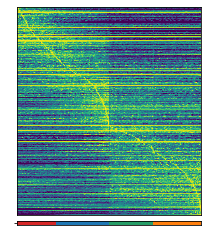

In [18]:
from matplotlib import gridspec
import matplotlib.colors as colors

plot_list = [*sorted_genes_early_late]
plot_df = MC_df_rolling_norm[plot_list].transpose()
plot_df = plot_df.fillna(0)

plot_df_norm = plot_df
#plot_df_norm = plot_df.apply(lambda x: x/np.amax(x), axis=1)


plt.rcParams["figure.figsize"] = 2.7,3.1
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 0.09])
#gs.update(hspace=0.05)


ax1 = plt.subplot(gs[0])
ax1.imshow(plot_df, aspect='auto', cmap='viridis', interpolation='none')

plt.sca(ax1)
plt.yticks([])
plt.xticks([])
#plt.xticks(np.arange(1, len(MC_df_rolling['rank'])+1, 300))

ax2 = plt.subplot(gs[1])
ax2.imshow([path_leiden_df], cmap=cmap, aspect='auto', vmin=0, vmax=len(color_list),
           interpolation='none')
plt.sca(ax2)

group_list = [' ']
plt.yticks(np.arange(len(group_list)), (group_list))
plt.xticks([])
#plt.xticks(np.arange(1, len(MC_df_rolling['rank'])+1, 300))
plt.tick_params(labelsize=8)
plt.tight_layout(pad=0.05, h_pad=0.005)
#plt.savefig("./figures/imshow_rollavg_20Sep21.tiff", dpi=600)
plt.show()

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

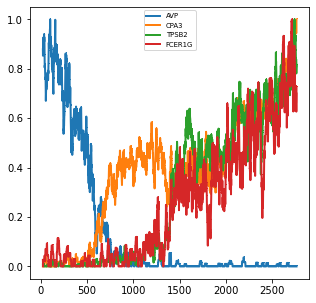

In [20]:
# Plot dynamically regulated genes that trend up, up/down, and down in path
dynamic_genes_to_plot = ['AVP', 'CPA3', 'TPSB2', 'FCER1G']

plt.figure(figsize=(5,5))
for gene in dynamic_genes_to_plot:
    plt.plot(MC_df_rolling_norm['rank'], MC_df_rolling_norm[gene],
             label=gene, marker=',', linewidth='2')
plt.legend(fontsize='x-small')
plt.show()

In [21]:
MC_df_dynamic_corr = MC_df.corr(method='spearman')

In [94]:
MC_df_dynamic_corr.loc['FCER1G']

HCST      0.055466
YPEL5    -0.009681
WDR43    -0.123313
PPP1CB    0.038103
SNRPB     0.017807
            ...   
CDC34     0.037528
SYT11    -0.066912
SNHG17   -0.024869
RAB27B    0.116047
rank      0.545229
Name: FCER1G, Length: 2051, dtype: float64

In [24]:
pseudo_corr_list = list(MC_df_dynamic_corr[MC_df_dynamic_corr.loc['rank'] > 0.5].index)
pseudo_corr_df = MC_df_dynamic_corr.loc[pseudo_corr_list, pseudo_corr_list]

In [25]:
pseudo_corr_df.loc['FCER1G']

AC244502.1    0.359132
DAD1          0.339329
P4HB          0.400185
RHBDD2        0.418978
CAPG          0.359329
                ...   
SEC61B        0.455562
FTH1          0.479633
CD82          0.353183
PRG2          0.475180
rank          0.545229
Name: FCER1G, Length: 85, dtype: float64

In [26]:
pseudo_corr_list_neg = list(MC_df_dynamic_corr[MC_df_dynamic_corr.loc['rank'] < -0.5].index)
pseudo_corr_df_neg = MC_df_dynamic_corr.loc[pseudo_corr_list_neg, pseudo_corr_list_neg]

In [27]:
pseudo_corr_df_neg

RPS19   ZFP36L2       AVP     PCDH9     RPS4X    NFKBIA  \
RPS19       1.000000  0.301877  0.425139  0.268065  0.530030  0.312981   
ZFP36L2     0.301877  1.000000  0.577786  0.339535  0.261801  0.329397   
AVP         0.425139  0.577786  1.000000  0.423081  0.382318  0.391940   
PCDH9       0.268065  0.339535  0.423081  1.000000  0.296798  0.353432   
RPS4X       0.530030  0.261801  0.382318  0.296798  1.000000  0.337395   
...              ...       ...       ...       ...       ...       ...   
ENO1        0.338402  0.270949  0.397098  0.304237  0.238905  0.383420   
MDK         0.358264  0.482299  0.569332  0.424941  0.373608  0.404994   
AC253572.2  0.287885  0.356898  0.504936  0.370374  0.333800  0.369492   
LINC02573   0.337846  0.239090  0.297676  0.315482  0.305883  0.337700   
C1QTNF4     0.385398  0.440150  0.567232  0.271192  0.261494  0.327804   

             SLC25A3     IFI16    GLIPR1    NAP1L1  ...     CSF3R      FHL1  \
RPS19       0.326556  0.273538  0.320667  0.412615  ...  0.429067  0.329014   
ZFP36L2     0.191360  0.305870  0.454714  0.425160  ...  0.466746  0.301723   
AVP         0.271413  0.365135  0.552278  0.518654  ...  0.565706  0.364861   
PCDH9       0.321650  0.349187  0.341636  0.499457  ...  0.385392  0.380459   
RPS4X       0.253009  0.268430  0.281268  0.298167  ...  0.334013  0.280483   
...              ...       ...       ...       ...  ...       ...       ...   
ENO1        0.444156  0.312598  0.338067  0.506946  ...  0.431002  0.325217   
MDK         0.349062  0.367740  0.425177  0.547137  ...  0.509544  0.373272   
AC253572.2  0.249612  0.309518  0.381824  0.429852  ...  0.414422  0.280241   
LINC02573   0.397612  0.353278  0.266915  0.498166  ...  0.393208  0.347913   
C1QTNF4     0.253779  0.331384  0.495143  0.455632  ...  0.520606  0.308923   

              SMIM24  AJ009632.2  AC245014.3      ENO1       MDK  AC253572.2  \
RPS19       0.339941    0.343714    0.282871  0.338402  0.358264    0.287885   
ZFP36L2     0.312761    0.478525    0.347495  0.270949  0.482299    0.356898   
AVP         0.366280    0.618577    0.464475  0.397098  0.569332    0.504936   
PCDH9       0.271898    0.414207    0.342616  0.304237  0.424941    0.370374   
RPS4X       0.237216    0.346111    0.319479  0.238905  0.373608    0.333800   
...              ...         ...         ...       ...       ...         ...   
ENO1        0.356729    0.343234    0.328529  1.000000  0.383666    0.349410   
MDK         0.373798    0.521505    0.411290  0.383666  1.000000    0.440265   
AC253572.2  0.279134    0.445333    0.639956  0.349410  0.440265    1.000000   
LINC02573   0.333055    0.302475    0.238058  0.318528  0.355693    0.273911   
C1QTNF4     0.399563    0.460604    0.338739  0.376250  0.412448    0.362687   

            LINC02573   C1QTNF4  
RPS19        0.337846  0.385398  
ZFP36L2      0.239090  0.440150  
AVP          0.297676  0.567232  
PCDH9        0.315482  0.271192  
RPS4X        0.305883  0.261494  
...               ...       ...  
ENO1         0.318528  0.376250  
MDK          0.355693  0.412448  
AC253572.2   0.273911  0.362687  
LINC02573    1.000000  0.276420  
C1QTNF4      0.276420  1.000000  

[80 rows x 80 columns]

In [28]:
pseudo_corr_list_neg_toplot = []
for gene in pseudo_corr_list_neg:
    if gene != 'rank':
        pseudo_corr_list_neg_toplot.append(gene)

In [29]:
pseudo_corr_list_neg_toplot

['RPS19',
 'ZFP36L2',
 'AVP',
 'PCDH9',
 'RPS4X',
 'NFKBIA',
 'SLC25A3',
 'IFI16',
 'GLIPR1',
 'NAP1L1',
 'EIF3E',
 'GAS5',
 'MGST3',
 'NACA',
 'BAALC',
 'MLLT3',
 'SEPTIN6',
 'LAPTM4B',
 'RPL30',
 'CD34',
 'RPS2',
 'TKT',
 'NPR3',
 'RPL29',
 'RPS3A',
 'HINT1',
 'RPL3',
 'BTF3',
 'CRHBP',
 'MEF2C',
 'SSBP2',
 'RPL13',
 'RPL9',
 'PROM1',
 'RPS15A',
 'MMRN1',
 'SPINK2',
 'HOPX',
 'PLAC8',
 'LST1',
 'AIF1',
 'TFPI',
 'HLA-DRA',
 'HLA-DRB1',
 'HLA-DPB1',
 'HLA-DPA1',
 'RPS18',
 'BIN1',
 'CD74',
 'H2AFY',
 'RPL32',
 'IRF1',
 'NPM1',
 'SERPINB6',
 'EGFL7',
 'RPL7A',
 'RPL18A',
 'RPL5',
 'NPDC1',
 'RGS10',
 'GBP4',
 'GSTP1',
 'ID1',
 'NRIP1',
 'LMO2',
 'RPS3',
 'ID3',
 'RPL11',
 'YBX3',
 'PPA1',
 'CSF3R',
 'FHL1',
 'SMIM24',
 'AJ009632.2',
 'AC245014.3',
 'ENO1',
 'MDK',
 'AC253572.2',
 'LINC02573',
 'C1QTNF4']

In [30]:
pseudo_corr_list_toplot = []
for gene in pseudo_corr_list:
    if gene != 'rank':
        pseudo_corr_list_toplot.append(gene)

In [31]:
len(pseudo_corr_list_toplot)

84

In [32]:
cols_to_norm = [*pseudo_corr_list_toplot]
other_cols = MC_df.loc[:,~MC_df.columns.isin(cols_to_norm)]
MC_df_norm = MC_df[cols_to_norm]
MC_df_norm=(
    MC_df_norm)/(MC_df_norm.max())
MC_df_norm = pd.concat([MC_df_norm, other_cols], axis=1)

In [33]:
path_df = MC_df_norm['rank']
leiden_df = sc.get.obs_df(adata2, 
                                 keys=['leiden'])
path_leiden_df = pd.concat([path_df, leiden_df], axis=1)
path_leiden_df = path_leiden_df.dropna()
path_leiden_df = path_leiden_df['leiden'].astype('float64')
path_leiden_df = path_leiden_df.transpose()

In [34]:
for gene in pseudo_corr_list_toplot:
    if gene.startswith('FC'):
        print(gene)

FCER1A
FCER1G


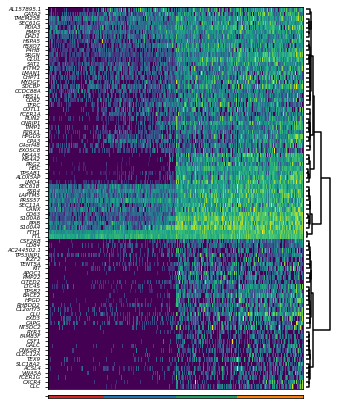

In [35]:
plot_list = [*pseudo_corr_list_toplot]
plot_df = MC_df_norm[plot_list].transpose()
plot_df = plot_df.fillna(0)

plot_df_norm = plot_df
#plot_df_norm = plot_df.apply(lambda x: x/np.amax(x), axis=1)

# Cluster row and create dendrogram
row_link = hierarchy.linkage(plot_df_norm, method="ward")
row_dendro = hierarchy.dendrogram(row_link, no_plot=True)
row_order = row_dendro["leaves"][::-1]

plt.rcParams["figure.figsize"] = 4.5,5.5
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 0.03]) #, hspace=0.03

ax1 = plt.subplot(gs[0])
plot_df_norm = plot_df_norm.iloc[row_order]
ax1.imshow(plot_df_norm, aspect='auto', cmap='viridis', interpolation='none')
plt.sca(ax1)
# Shuffle y/gene-labels according to dendrogram row_order
plot_list_reordered = [plot_list[i] for i in row_order]
plt.yticks(np.arange(len(plot_list_reordered)), (plot_list_reordered), size=5.5,
           rotation=-0, va='center', rotation_mode='anchor')
labels = ax1.get_yticklabels() # set italic style for yticks
[label.set_fontstyle('italic') for label in labels]

plt.xticks([])
divider = make_axes_locatable(ax1)
row_ax = divider.append_axes("right", size="10%", pad='1%')
dendrogram(row_link, no_labels=True, orientation="right", ax=row_ax, color_threshold=0, above_threshold_color="black")
row_ax.axis("off")

ax2 = plt.subplot(gs[1])
ax2.imshow([path_leiden_df], cmap=cmap, aspect='auto', vmin=0, vmax=len(color_list),
           interpolation='none')
# Pad ax2(cluster_timeline) using same dimensions as dendrogram
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="10%", pad='1%', add_to_figure=False)
plt.sca(ax2)
group_list = [' ']
plt.xticks([])
plt.tick_params(labelsize=8)
plt.yticks(np.arange(len(group_list)), (group_list))

plt.tight_layout(h_pad=0.003, pad=0.005)
#plt.savefig("./figures/imshow_dygene_corrfilter_20Sep21.tiff", dpi=600)
plt.show()

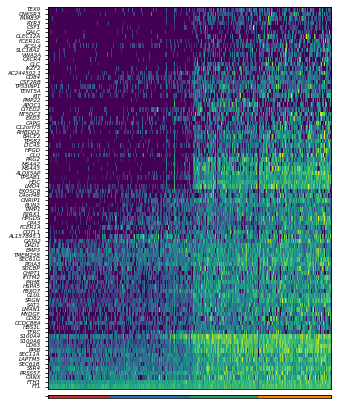

In [36]:
# Without dendrogram tree, with optimal leave ordering
plot_list = [*pseudo_corr_list_toplot]
plot_df = MC_df_norm[plot_list].transpose()
plot_df = plot_df.fillna(0)

plot_df_norm = plot_df
#plot_df_norm = plot_df.apply(lambda x: x/np.amax(x), axis=1)

# Cluster row and create dendrogram
row_link = hierarchy.linkage(plot_df_norm, method="ward", optimal_ordering=True)
row_dendro = hierarchy.dendrogram(row_link, no_plot=True)
row_order = row_dendro["leaves"][::1]

plt.rcParams["figure.figsize"] = 4.5,5.5
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 0.03]) #, hspace=0.03

ax1 = plt.subplot(gs[0])
plot_df_norm = plot_df_norm.iloc[row_order]
ax1.imshow(plot_df_norm, aspect='auto', cmap='viridis', interpolation='none')
plt.sca(ax1)
# Shuffle y/gene-labels according to dendrogram row_order
plot_list_reordered = [plot_list[i] for i in row_order]
plt.yticks(np.arange(len(plot_list_reordered)), (plot_list_reordered), size=5.5,
           rotation=-0, va='center', rotation_mode='anchor')
labels = ax1.get_yticklabels() # set italic style for yticks
[label.set_fontstyle('italic') for label in labels]

plt.xticks([])


""" # Dendrogram printing function not properly optimised, recalculating, leading to erronous result
#divider = make_axes_locatable(ax1)
#row_ax = divider.append_axes("right", size="10%", pad='1%')
#dendrogram(row_link, no_labels=True, orientation="right", ax=row_ax, color_threshold=0, above_threshold_color="black")
#row_ax.axis("off")
"""

ax2 = plt.subplot(gs[1])
ax2.imshow([path_leiden_df], cmap=cmap, aspect='auto', vmin=0, vmax=len(color_list),
           interpolation='none')
plt.sca(ax2)
group_list = [' ']
plt.xticks([])
plt.tick_params(labelsize=8)
plt.yticks(np.arange(len(group_list)), (group_list))

plt.tight_layout(h_pad=0.003, pad=0.005)
#plt.savefig("./figures/imshow_dygene_corrfilter_18Nov21.tiff", dpi=600)
plt.show()

In [150]:
Motakis_etal_list = ['KIT',
'IL1RL1',
'FCER1A',
'MS4A2',
'ENPP3',
'HDC',
'TPSAB1',
'TPSB2',
'TPSD1',
'CMA1',
'CPA3',
'CTSG',
'HPGDS',
'LTC4S']

In [154]:
count = 0
for gene in Motakis_etal_list:
    if gene not in pseudo_corr_list_toplot:
        print(gene)
    else:
        count += 1
print(count)
print(len(Motakis_etal_list))

IL1RL1
ENPP3
TPSD1
CMA1
CTSG
9
14


In [138]:
interest_list = ['CPA3', 'TPSB2', "TPSAB1", 'HDC', 'SRGN', 'FCER1A', 'MS4A2', 'FCER1G', 'KIT',
                'CD63', 'HPGDS', 'HPGD']
print(len(interest_list))
count = 0
for gene in pseudo_corr_list_toplot:
    if gene in interest_list:
        print(gene)
        count += 1
print(count)

12
FCER1A
FCER1G
TPSAB1
TPSB2
HPGD
CPA3
HPGDS
KIT
HDC
CD63
SRGN
MS4A2
12


In [139]:
cols_to_norm_neg = [*pseudo_corr_list_neg_toplot]
other_cols_neg = MC_df.loc[:,~MC_df.columns.isin(cols_to_norm_neg)]
MC_df_norm_neg = MC_df[cols_to_norm_neg]
MC_df_norm_neg=(
    MC_df_norm_neg)/(MC_df_norm_neg.max())
MC_df_norm_neg = pd.concat([MC_df_norm_neg, other_cols_neg], axis=1)

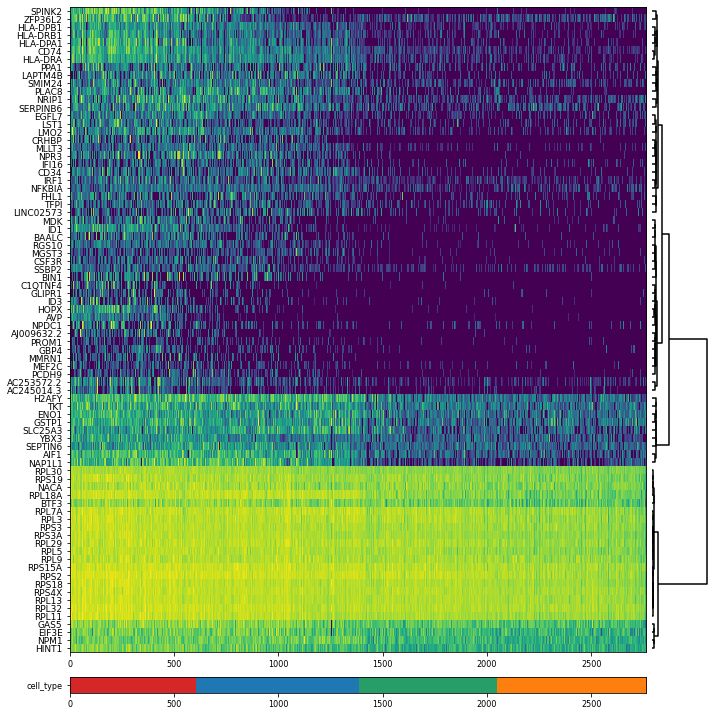

In [140]:
plot_list = [*pseudo_corr_list_neg_toplot]
plot_df = MC_df_norm_neg[plot_list].transpose()
plot_df = plot_df.fillna(0)

plot_df_norm = plot_df
#plot_df_norm = plot_df.apply(lambda x: x/np.amax(x), axis=1)

# Cluster row and create dendrogram
row_link = hierarchy.linkage(plot_df_norm, method="ward")
row_dendro = hierarchy.dendrogram(row_link, no_plot=True)
row_order = row_dendro["leaves"][::-1]

plt.rcParams["figure.figsize"] = 10,10
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 0.1]) 

ax1 = plt.subplot(gs[0])
plot_df_norm = plot_df_norm.iloc[row_order]
ax1.imshow(plot_df_norm, aspect='auto', cmap='viridis', interpolation='None')
plt.sca(ax1)
# Shuffle y/gene-labels according to dendrogram row_order
plot_list_reordered = [plot_list[i] for i in row_order]
plt.yticks(np.arange(len(plot_list_reordered)), (plot_list_reordered), size=9)
#plt.xticks(np.arange(1, len(MC_df['rank'])+1, 300))
divider = make_axes_locatable(ax1)
row_ax = divider.append_axes("right", size="10%", pad='1%')
dendrogram(row_link, no_labels=True, orientation="right", ax=row_ax, color_threshold=0, above_threshold_color="black")
row_ax.axis("off")

ax2 = plt.subplot(gs[1])
ax2.imshow([path_leiden_df], cmap=cmap, aspect='auto', vmin=0, vmax=len(color_list),
           interpolation='none')
# Pad ax2(cluster_timeline) using same dimensions as dendrogram
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="10%", pad='1%', add_to_figure=False)
plt.sca(ax2)
group_list = ['cell_type']
plt.yticks(np.arange(len(group_list)), (group_list))

plt.tight_layout()
#plt.savefig("./figures/imshow_dygene_corrfilter.pdf", dpi=200)
plt.show()

In [141]:
path_df = MC_df_rolling_norm['rank']
leiden_df = sc.get.obs_df(adata2, 
                                 keys=['leiden'])
path_leiden_df = pd.concat([path_df, leiden_df], axis=1)
path_leiden_df = path_leiden_df.dropna()
path_leiden_df = path_leiden_df['leiden'].astype('float64')
path_leiden_df = path_leiden_df.transpose()

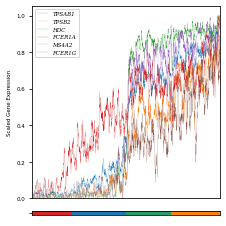

In [149]:
dynamic_genes_to_plot = ['TPSAB1', 'TPSB2', 'HDC', 'FCER1A', 'MS4A2', 'FCER1G']

plt.rcParams["figure.figsize"] = 3.19, 3.19
fig, (ax1, ax2) = plt.subplots(2, sharex=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 0.1]) 

ax1 = plt.subplot(gs[0])
for gene in dynamic_genes_to_plot:
    ax1.plot(MC_df_rolling_norm['rank'], MC_df_rolling_norm[gene],
            label=gene, linewidth='0.2')
plt.ylabel('Scaled Gene Expression', fontsize=5.5)
plt.tick_params(labelsize=5.5)
plt.ylim(ymin=0.0)
plt.xlim(xmin=0.0, xmax=len(MC_df_rolling_norm))
plt.xticks([])
plt.sca(ax1)
ax1.legend(prop ={'size':5.5, 'family':'serif', 'style':'italic'})


ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.imshow([path_leiden_df], cmap=cmap, aspect='auto', vmin=0, vmax=len(color_list),
           interpolation='none')
plt.sca(ax2)
group_list = [' ']
plt.xticks([])
plt.tick_params(labelsize=5.5)
plt.yticks(np.arange(len(group_list)), (group_list))

plt.tight_layout()
plt.savefig("./figures/dygene_corrfilter_trend_thin_20Sep21.tiff", dpi=600)
plt.show()

In [98]:
#adata.write_h5ad(filename="./Buffy210208_18Aug.h5ad")